## 환경설정

In [ ]:
project_name = "개 고양이 분류" # 프로젝트 이름
class_info = "1차수 A반" # 차수 정보
email = "" # 회사 이메일(본인의 회사 이메일 입력)

## 모듈 설치 및 데이터 다운로드

In [ ]:
!pip install --upgrade mySUNI -q

import mySUNI
from mySUNI import cds, utils
import urllib.request
import zipfile


project = cds.Project(project_name, class_info, email)
project.edu_name = 'SUNI_딥러닝'

# 이메일 설정 확인
if not project.email:
    raise print("[이메일이 누락되었습니다] 이메일을 설정해 주세요↑↑↑")


print('===' * 15)
print(f'패키지버전: {mySUNI.__version__}')
print('===' * 15)
print(f'프로젝트명: {project_name}\n차수 정보 : {class_info}\n이  메  일: {email}')
print('===' * 15)

# 데이터셋 다운로드
print('1) TRAIN 데이터셋 다운로드...')
url = 'https://www.dropbox.com/s/vcq6typ3sw65kb3/train.zip?dl=1'
urllib.request.urlretrieve(url, 'train.zip')
local_zip = 'train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('cats-dogs/train')
zip_ref.close()

print('2) TEST 데이터셋 다운로드...')
url = 'https://www.dropbox.com/s/zcifc1nnzpn971z/test.zip?dl=1'
urllib.request.urlretrieve(url, 'test.zip')
local_zip = 'test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('cats-dogs/test/test')
zip_ref.close()

url = 'https://www.dropbox.com/s/yfi79nde5ubbvni/submission.csv?dl=1'
urllib.request.urlretrieve(url, 'cats-dogs/submission.csv')
print('===' * 15)
print('[데이터셋 다운로드 완료]')

## 필요한 모듈 import 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Data 경로 설정
DATA_DIR = 'data'

# 경고 무시
warnings.filterwarnings('ignore')

SEED=123

## 프로젝트 개요

본 실습에서는 개, 고양이 이미지 분류기를 만듭니다.

- train 폴더: 학습용 이미지 데이터셋
- test 폴더: 예측용 이미지 데이터셋

**폴더 위치**
- 학습용 데이터셋: cats-dogs/train
- 예측용 데이터셋: cats-dogs/test

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
TRAIN_DIR = './cats-dogs/train'
TEST_DIR = './cats-dogs/test'

Found 2000 images belonging to 2 classes.
(32, 224, 224, 3) (32, 2)
[1. 0.]


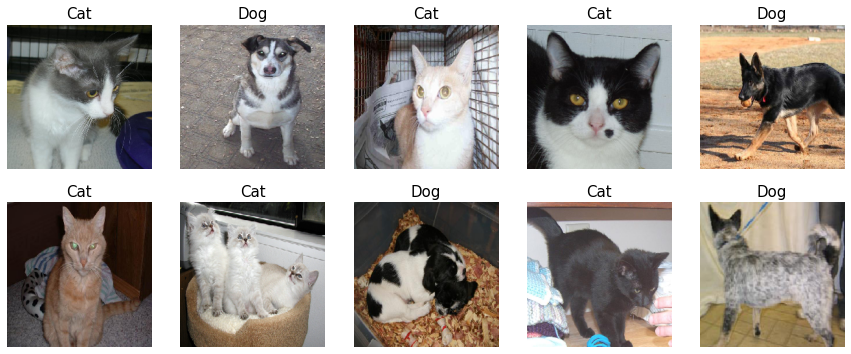

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

class_map = {
    0: 'Cat',
    1: 'Dog', 
}

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(TRAIN_DIR, 
                                                          target_size=(224, 224), 
                                                          batch_size=32
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    break
plt.show()

## ↓↓↓ 코드 구현 ↓↓↓

### ImageDataGenerator

In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect', 
    validation_split=0.2
)

In [ ]:
training_generator = training_datagen.flow_from_directory(TRAIN_DIR, 
                                                          batch_size=32, 
                                                          target_size=(224, 224), 
                                                          class_mode='categorical', 
                                                          subset='training',
                                                         )

Found 1600 images belonging to 2 classes.


In [ ]:
validation_generator = training_datagen.flow_from_directory(TRAIN_DIR, 
                                                            batch_size=32, 
                                                            target_size=(224, 224), 
                                                            class_mode='categorical',
                                                            subset='validation', 
                                                           )

Found 400 images belonging to 2 classes.


### 모델 정의 (Sequential)

In [ ]:
model = Sequential([
    # Conv2D, MaxPooling2D 조합으로 층을 쌓습니다. 첫번째 입력층의 input_shape은 (224, 224, 3)으로 지정합니다.
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    # 2D -> 1D로 변환을 위하여 Flatten 합니다.
    Flatten(), 
    # 과적합 방지를 위하여 Dropout을 적용합니다.
    Dropout(0.25),
    Dense(256, activation='relu'),
    Dense(32, activation='relu'),
    # Classification을 위한 Softmax 
    # 출력층의 갯수는 클래스의 갯수와 동일하게 맞춰줍니다 (2개), activation도 잊지마세요!
    Dense(2, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 24, 128)      

### 컴파일 (compile)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

### 학습 (fit)

- ModelCheckpoint 설정
- fit() 함수 구현
- checkpoint 로드

In [ ]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
model.fit(training_generator, 
          validation_data=(validation_generator),
          epochs=20,
          callbacks=[checkpoint],
          )

Epoch 1/20
50/50 [==============================] - 15s 303ms/step - loss: 0.5782 - acc: 0.7000 - val_loss: 0.6118 - val_acc: 0.6925

Epoch 00001: val_loss improved from 0.61275 to 0.61181, saving model to tmp_checkpoint.ckpt
Epoch 2/20
50/50 [==============================] - 15s 298ms/step - loss: 0.5665 - acc: 0.7063 - val_loss: 0.6298 - val_acc: 0.6775

Epoch 00002: val_loss did not improve from 0.61181
Epoch 3/20
50/50 [==============================] - 15s 300ms/step - loss: 0.5524 - acc: 0.7088 - val_loss: 0.6055 - val_acc: 0.6700

Epoch 00003: val_loss improved from 0.61181 to 0.60554, saving model to tmp_checkpoint.ckpt
Epoch 4/20
50/50 [==============================] - 15s 299ms/step - loss: 0.5421 - acc: 0.7225 - val_loss: 0.5737 - val_acc: 0.6950

Epoch 00004: val_loss improved from 0.60554 to 0.57371, saving model to tmp_checkpoint.ckpt
Epoch 5/20
50/50 [==============================] - 15s 302ms/step - loss: 0.5183 - acc: 0.7344 - val_loss: 0.5649 - val_acc: 0.7175

Epo

In [ ]:
model.load_weights('tmp_checkpoint.ckpt')

## 전이학습 (Transfer Learning)

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
transfer_model.trainable=False

58900480/58889256 [==============================] - 6s 0us/step


In [ ]:
model = Sequential([
    transfer_model,
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 27,626,178
Trainable params: 12,911,490
Non-trainable params: 14,714,688
_________________________________

이하 코드는 동일

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
model.fit(training_generator, 
          validation_data=(validation_generator),
          epochs=10,
          callbacks=[checkpoint],
          )

Epoch 1/5
50/50 [==============================] - 19s 341ms/step - loss: 0.8137 - acc: 0.7200 - val_loss: 0.3439 - val_acc: 0.8550

Epoch 00001: val_loss improved from inf to 0.34389, saving model to tmp_checkpoint.ckpt
Epoch 2/5
50/50 [==============================] - 16s 316ms/step - loss: 0.3436 - acc: 0.8306 - val_loss: 0.4055 - val_acc: 0.8250

Epoch 00002: val_loss did not improve from 0.34389
Epoch 3/5
50/50 [==============================] - 16s 316ms/step - loss: 0.3257 - acc: 0.8569 - val_loss: 0.3424 - val_acc: 0.8375

Epoch 00003: val_loss improved from 0.34389 to 0.34238, saving model to tmp_checkpoint.ckpt
Epoch 4/5
50/50 [==============================] - 16s 316ms/step - loss: 0.2989 - acc: 0.8587 - val_loss: 0.2866 - val_acc: 0.8825

Epoch 00004: val_loss improved from 0.34238 to 0.28659, saving model to tmp_checkpoint.ckpt
Epoch 5/5
50/50 [==============================] - 16s 314ms/step - loss: 0.2656 - acc: 0.8875 - val_loss: 0.2774 - val_acc: 0.8800

Epoch 00005:

In [ ]:
model.load_weights('tmp_checkpoint.ckpt')

### 예측

In [ ]:
# 아래의 코드는 수정하지 않습니다.
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                  target_size=(224, 224), 
                                                  batch_size=1,
                                                  shuffle=False                                                  
                                                  )

Found 1000 images belonging to 1 classes.


In [ ]:
# 아래의 코드는 수정하지 않습니다.
pred = model.predict(test_generator)
your_answer = pred.argmax(axis=1)

## 결과 제출

### 순서대로 평가가 진행됩니다. 실행은 1회만 해주세요.

- 느리다고 중지 후 다시 평가 코드를 실행하는 경우 제출 과정에서 패널티가 발생할 수 있습니다. (제출 횟수 이슈 발생 가능)

- 전체 점수는 [평가시스템](http://manage.jaen.kr)에서 확인할 수 있습니다.
    - 프로젝트 > 손글씨 이미지 분류 > 리더보드 > 같은 반 리더보드

아래 Cell을 실행하여 예측 결과 업데이트

In [ ]:
# 예측 결과 업데이트
submission = pd.read_csv(os.path.join('cats-dogs', 'submission.csv'))
submission['label'] = your_answer
display(submission)

# 제출
project.email = email
project.submit(submission)

,image,label
0,test_0000.jpg,1
1,test_0001.jpg,0
2,test_0002.jpg,0
3,test_0003.jpg,0
4,test_0004.jpg,1
...,...,...
995,test_0995.jpg,1
996,test_0996.jpg,0
997,test_0997.jpg,1
998,test_0998.jpg,1


파일을 저장하였습니다. 파일명: submission-13-43-05.csv
제출 여부 :success
오늘 제출 횟수 : 5
제출 결과:0.907
